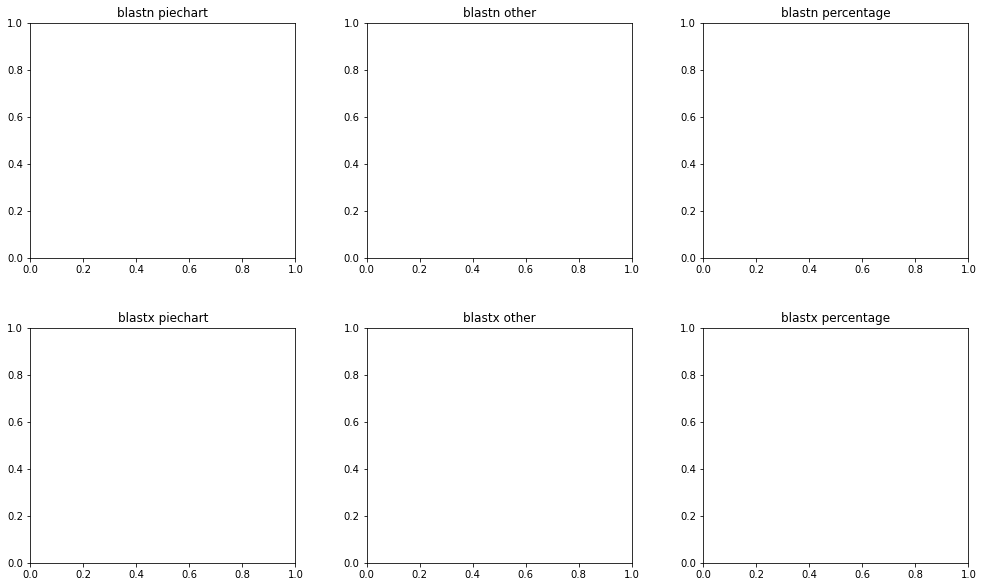

In [37]:
#select intepreter and change environment to anaconda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import xmltodict
from xml.dom import minidom
import time


#handles command line input parameter
import sys
import os

# testing file is from 10,000 reads, so mapping percentage is expected to be out of 10 mil
blast_tsv_file = 'LARP6.TGFb_IN1.umi.r1.fq_unmappedblast_downsampled_blastn.tsv'
blast_tsv_file2 = 'LARP6.TGFb_IN1.umi.r1.fq_unmappedblast_downsampled_blastx.tsv'
piePath = 'Combined.png'
piePathSample = os.path.splitext(piePath)[0]
piePathSample2 = os.path.split(piePathSample)
pieName = piePathSample2[1]

#ncbi query functions
def esearch(term, db='gds'):
    """
    Queries NCBI using the esearch utility. GEO ('gds') database is used as default for search term.
    """
    url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db={db}&term={term}&retmax=5000&usehistory=y'
    response = urllib.request.urlopen(url)
    return response.read()


def get_esummary(esearch_string, db='gds'):
    """
    Parses a http response in XML format to obtain the webenv and querykey tokens.
    Uses NCBI eutils to transform these tokens into web summaries of GEO (db='gds') datasets.
    """
    xmldoc = minidom.parseString(esearch_string)
    try:
        webenv = xmldoc.getElementsByTagName('WebEnv')[0].firstChild.data
        querykey = xmldoc.getElementsByTagName('QueryKey')[0].firstChild.data
        host = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi'
        params = f'?db={db}&version=2.0&query_key={querykey}&WebEnv={webenv}'
        url = host + params
        response = urllib.request.urlopen(url)
        return response.read()
    except IndexError as e:
        print(f"Unparsable publication string ({e}, search={esearch_string}")
        return ""

#matplotlib to build the piechart
fig, ((ax1, ax2, ax5), (ax3, ax4, ax6)) = plt.subplots(2, 3, figsize=(9, 5))
fig.tight_layout(h_pad=2)
plt.subplots_adjust(bottom=0, right=1.5, top=1.5)
ax1.set_title('blastn piechart')
ax2.set_title('blastn other')
ax3.set_title('blastx piechart')
ax4.set_title('blastx other')
ax5.set_title('blastn percentage')
ax6.set_title('blastx percentage')





# Read the blast n file
df = pd.read_csv(blast_tsv_file, header=None, sep='\t')
df.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']

df2 = df[['qseqid','sseqid','evalue']].copy()

# Read the blast x file
df4 = pd.read_csv(blast_tsv_file2, header=None, sep='\t')
df4.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']




# ### still need to reorganize the code for each different file below.


# #blast n output default is by best hit/lowest e value score, therefore add the first sseqid result for each qseqid
# sseqid_list1 = []
# qseqid_list1 = []
# for idx in df.index:
#         if df['qseqid'][idx] not in qseqid_list1:
#                 qseqid_list1.append(df['qseqid'][idx])
#                 sseqid_list1.append(df['sseqid'][idx])
# sseqid_np1 = np.array(sseqid_list1)

# #blast x output default is by best hit/lowest e value score, therefore add the first sseqid result for each qseqid
# sseqid_list2 = []
# qseqid_list2 = []
# for idx in df4.index:
#         if df4['qseqid'][idx] not in qseqid_list2:
#                 qseqid_list2.append(df4['qseqid'][idx])
#                 sseqid_list2.append(df4['sseqid'][idx])
# sseqid_np2 = np.array(sseqid_list2)

# df3 = pd.DataFrame(data = sseqid_np1, columns=['sseqid'])
# print(df3)
# num_seqs = df3.size
# df5 = pd.DataFrame(data = sseqid_np2, columns=['sseqid'])
# print(df5)
# num_seqs2 = df5.size

# sseq_count_series1 = df3['sseqid'].value_counts()
# print(sseq_count_series1)

# sseq_count_series4 = df5['sseqid'].value_counts()
# print(sseq_count_series4)

# #loop through series to determine which elements to remove and add into "other" column
# to_remove1 = []
# other_count1 = 0
# otherDict1 = {}
# to_remove2 = []
# other_count2 = 0
# otherDict2 = {}

# #blastn number mapped
# print(num_seqs)

# #blastx number mapped
# print(num_seqs2)

# #taking 1% of number of sequences for blast n
# only_2_n = 2
# for index,values in sseq_count_series1.iteritems():
#         if(values < (0.001)*(num_seqs)) or only_2_n == 0:
#                 to_remove1.append(index)
#                 other_count1 += values
#                 otherDict1[values] = index
#         else:
#             only_2_n -= 1

# #taking 1% of number of sequences for blast x
# only_2_x = 2
# for index,values in sseq_count_series4.iteritems():
#         if(values < (0.001)*(num_seqs2)) or only_2_x == 0:
#                 to_remove2.append(index)
#                 other_count2 += values
#                 otherDict2[values] = index
#         else:
#             only_2_x -= 1

# otherAnswer1 = []
# increment1 = 0
# for key,value in sorted(otherDict1.items(),reverse=True):
#         if increment1 <= 2:
#                 otherAnswer1.append((key,value))
#                 increment1+=1
#         else:
#              break              
                
# otherAnswer2 = []
# increment2 = 0
# for key,value in sorted(otherDict2.items(),reverse=True):
#         if increment2 <= 2:
#                 otherAnswer2.append((key,value))
#                 increment2+=1
#         else:
#              break

# gene_ratios = []
# gene_labels = []  
# gene_labels_raw = []  

# for idx in range(len(otherAnswer1)):
#         gene_ratios.append(otherAnswer1[idx][0]/other_count1)
#         gene_labels_raw.append(otherAnswer1[idx][1])

# #replace index sseqids with ncbi name
# for idx in range(len(gene_labels_raw)):
#         term = str(gene_labels_raw[idx])
#         print(term)
#         esearch_string = esearch(term=term, db='nucleotide')
#         time.sleep(0.1)
#         result = get_esummary(esearch_string=esearch_string, db='nucleotide')
#         result = xmltodict.parse(result)
#         sseq_name = result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
#         gene_labels.append(sseq_name)                          
                
# gene_ratios2 = []
# gene_labels2 = []
# gene_labels_raw2 = []

# for idx in range(len(otherAnswer2)):
#         gene_ratios2.append(otherAnswer2[idx][0]/other_count2)
#         gene_labels_raw2.append(otherAnswer2[idx][1])

# #replace index sseqids with ncbi name
# for idx in range(len(gene_labels_raw2)):
#         term = str(gene_labels_raw2[idx])
#         print(term)
#         esearch_string = esearch(term=term, db='protein')
#         time.sleep(0.3)
#         result = get_esummary(esearch_string=esearch_string, db='protein')
#         result = xmltodict.parse(result)
#         sseq_name = result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
#         gene_labels2.append(sseq_name) 
               
                

# #remove these elements from series
# sseq_count_series2 = sseq_count_series1.drop(to_remove1)
# sseq_count_series5 = sseq_count_series4.drop(to_remove2)

# sseq_name_list = []
# sseqid = []
# #replace index sseqids with ncbi name
# for index,values in sseq_count_series2.iteritems():
#         sseqid.append(index)
#         term = str(index)
#         esearch_string = esearch(term=term, db='nucleotide')
#         time.sleep(0.1)
#         result = get_esummary(esearch_string=esearch_string, db='nucleotide')
#         result = xmltodict.parse(result)
#         sseq_name = result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
#         sseq_name_list.append(sseq_name)
#         #sseq_count_series2.rename(index={index:sseq_name})
# #replace the sseqids with ncbi query names
# replacements = {sseqid:sseq_name_list for sseqid, sseq_name_list in zip(sseqid, sseq_name_list)}
# sseq_count_series3 = sseq_count_series2.rename(replacements)
# #sseq_count_series2 = sseq_count_series2.rename(index=dict(zip(sseq_name_list,sseqid)))

# #generate new pandas series with new element to concatenate with old series
# d = {'Other':other_count1}
# ser = pd.Series(data=d, index=['Other'])

# #append new element
# sseq_count = sseq_count_series3.append(ser)
# #print(sseq_count)

# #value_counts returns a pandas series so convert to a data frame
# sseq_count_df = pd.DataFrame({'sseqid':sseq_count.index, 'count':sseq_count.values})
# print(sseq_count_df)

# count = sseq_count_df['count']
# sseq = sseq_count_df['sseqid']



# sseq_name_list2 = []
# sseqid2 = []
# #replace index sseqids with ncbi name
# for index,values in sseq_count_series5.iteritems():
#         sseqid2.append(index)
#         term = str(index)
#         esearch_string = esearch(term=term, db='protein')
#         time.sleep(0.1)
#         result = get_esummary(esearch_string=esearch_string, db='protein')
#         result = xmltodict.parse(result)
#         sseq_name = result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
#         sseq_name_list2.append(sseq_name)
#         #sseq_count_series2.rename(index={index:sseq_name})
# #replace the sseqids with ncbi query names
# replacements2 = {sseqid2:sseq_name_list2 for sseqid2, sseq_name_list2 in zip(sseqid2, sseq_name_list2)}
# sseq_count_series6 = sseq_count_series5.rename(replacements2)
# #sseq_count_series2 = sseq_count_series2.rename(index=dict(zip(sseq_name_list,sseqid)))

# #generate new pandas series with new element to concatenate with old series
# d2 = {'Other':other_count2}
# ser2 = pd.Series(data=d2, index=['Other'])

# #append new element
# sseq_count2 = sseq_count_series6.append(ser2)
# #print(sseq_count)

# #value_counts returns a pandas series so convert to a data frame
# sseq_count_df2 = pd.DataFrame({'sseqid':sseq_count2.index, 'count':sseq_count2.values})
# print(sseq_count_df2)

# count2 = sseq_count_df2['count']
# sseq2 = sseq_count_df2['sseqid']

# bottom = 1
# width = 0.2

# wedges1, *_ = ax1.pie(count, labels = sseq, colors=None,autopct='%1.1f%%',startangle=45,
#         wedgeprops={"linewidth": 1, "edgecolor": "white"})

# for j, (height, label) in enumerate(reversed([*zip(gene_ratios, gene_labels)])):
#     bottom -= height
#     bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
#                  alpha=0.1 + 0.25 * j)
#     ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

# # ax2.set_title('Other unmapped reads')
# ax2.legend()
# ax2.axis('off')
# ax2.set_xlim(- 2.5 * 2, 2.5 * 2)



# bottom = 1
# width = 0.2

# wedges2, *_ = ax3.pie(count2, labels = sseq2, colors=None,autopct='%1.1f%%',startangle=45,
#         wedgeprops={"linewidth": 1, "edgecolor": "white"})

# for j, (height, label) in enumerate(reversed([*zip(gene_ratios2, gene_labels2)])):
#     bottom -= height
#     bc = ax4.bar(0, height, width, bottom=bottom, color='C0', label=label,
#                  alpha=0.1 + 0.25 * j)
#     ax4.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')
    
# # ax4.set_title('Other unmapped reads')
# ax4.legend()
# ax4.axis('off')
# ax4.set_xlim(- 2.5 * 2, 2.5 * 2)




# ### Get the percentage of the the blast n/x mapped results
# # for ax5
# ax5_percentages = [200 - num_seqs, num_seqs]
# ax5_labels = ['Unmapped', 'Mapped']
# ax5.pie(ax5_percentages, labels=ax5_labels, autopct='%1.1f%%',
#        colors=['skyblue', 'gray'], labeldistance=1.1)

# # for ax6
# ax6_percentages = [200 - num_seqs2, num_seqs2]
# ax6_labels = ['Unmapped', 'Mapped']
# ax6.pie(ax6_percentages, labels=ax6_labels, autopct='%1.1f%%',
#        colors=['skyblue', 'gray'], labeldistance=1.1)

# # Adding Circle in Pie chart
# circle1 = plt.Circle((0, 0), radius=0.6, color='white')
# ax5.add_patch(circle1)
# circle2 = plt.Circle((0, 0), radius=0.6, color='white')
# ax6.add_patch(circle2)

# text1 = str(num_seqs) + " out of 10000 sequences no mapping"
# text2 = str(num_seqs2) + " out of 10000 sequences no mapping"

# # plt.title('Blastn and Blastx Unmapped Sequences Summary ' + pieName)
# ax5.text(0.95, 2.2, text1, transform=ax6.transAxes, fontsize=14,
#         verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
# ax6.text(0.95, 0.95, text2, transform=ax6.transAxes, fontsize=14,
#         verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

# fig.tight_layout(pad=5.0)
# plt.show(block=True)
# plt.savefig(piePath,format='png',bbox_inches='tight')


In [18]:
dictionary = {}
for eachid,eachp in zip(df['sseqid'], df['pident']):
    if eachid not in dictionary:
        dictionary[eachid] = [eachp, 1]
    elif float(eachp) > dictionary[eachid][0]:
        dictionary[eachid] = [float(eachp), 1]
    elif float(eachp) == dictionary[eachid][0]:
        dictionary[eachid][1] += 1

dictionary = sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
print(dictionary[0])
print(dictionary[1])
print(dictionary[2])

('OV277454.1', [100.0, 48302])
('XR_006701964.1', [100.0, 31441])
('XR_006701925.1', [100.0, 31377])


In [44]:
term = 'PCO95652.1'

#term = str(index)
esearch_string = esearch(term=term, db='protein')
time.sleep(0.1)
result = get_esummary(esearch_string=esearch_string, db='protein')
result = xmltodict.parse(result)
sseq_name = result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
print(sseq_name)

hypothetical protein CP996_26250 [Escherichia coli]


In [1]:
dictionary2 = {}
for eachid,eachp in zip(df4['sseqid'], df4['pident']):
    if eachid not in dictionary2:
        dictionary2[eachid] = [eachp, 1]
    elif float(eachp) > dictionary2[eachid][0]:
        dictionary2[eachid] = [float(eachp), 1]
    elif float(eachp) == dictionary2[eachid][0]:
        dictionary2[eachid][1] += 1
        
dictionary2 = sorted(dictionary2.items(), key=lambda x:x[1], reverse=True)
for each in dictionary2:
    if float(each[1][0]) == float(100):
        print(each[0])

In [2]:
#select intepreter and change environment to anaconda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import xmltodict
from xml.dom import minidom
import time


#handles command line input parameter
import sys
import os

# testing file is from 10,000 reads, so mapping percentage is expected to be out of 10,000
blast_tsv_file = "fiftyX.tsv"
#blast_tsv_file2 = sys.argv[2]
#piePath = sys.argv[3]
#piePathSample = os.path.splitext(piePath)[0]
#piePathSample2 = os.path.split(piePathSample)
#pieName = piePathSample2[1]
filterlist = ['bacter', 'bacterium', 'strain', 'Homo sapiens', 'Mus musculus', 'virus']

#ncbi query functions
def esearch(term, db='gds'):
    """
    Queries NCBI using the esearch utility. GEO ('gds') database is used as default for search term.
    """
    url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db={db}&term={term}&retmax=5000&usehistory=y'
    response = urllib.request.urlopen(url)
    return response.read()


def get_esummary(esearch_string, db='gds'):
    """
    Parses a http response in XML format to obtain the webenv and querykey tokens.
    Uses NCBI eutils to transform these tokens into web summaries of GEO (db='gds') datasets.
    """
    xmldoc = minidom.parseString(esearch_string)
    try:
        webenv = xmldoc.getElementsByTagName('WebEnv')[0].firstChild.data
        querykey = xmldoc.getElementsByTagName('QueryKey')[0].firstChild.data
        host = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi'
        params = f'?db={db}&version=2.0&query_key={querykey}&WebEnv={webenv}'
        url = host + params
        response = urllib.request.urlopen(url)
        return response.read()
    except IndexError as e:
        print(f"Unparsable publication string ({e}, search={esearch_string}")
        return ""


# Read the blast n file
df = pd.read_csv(blast_tsv_file, header=None, sep='\t')
df.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']

df2 = df[['qseqid','sseqid','pident']].copy()

# Read the blast x file
#df3 = pd.read_csv(blast_tsv_file2, header=None, sep='\t')
#df3.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']
#df4 = df3[['qseqid','sseqid','pident']].copy()

dictionary1 = {}
for eachid,eachp in zip(df2['sseqid'], df2['pident']):
    if eachid not in dictionary1:
        dictionary1[eachid] = [eachp, 1]
    elif float(eachp) > dictionary1[eachid][0]:
        dictionary1[eachid] = [float(eachp), 1]
    elif float(eachp) == dictionary1[eachid][0]:
        dictionary1[eachid][1] += 1

dictionary1 = sorted(dictionary1.items(), key=lambda x:x[1], reverse=True)
ncbilist1 = []

for each in dictionary1:
    if float(each[1][0]) == float(100):
        checker = 0
        term = str(each[0])
        #print(term)
        esearch_string = esearch(term=term, db='protein')
        time.sleep(0.1)
        result = get_esummary(esearch_string=esearch_string, db='protein')
        result = xmltodict.parse(result)
        #print(result)
        if 'eSummaryResult' not in result:
            continue
        elif 'DocumentSummarySet' not in result['eSummaryResult']:
            continue
        elif 'DocumentSummary' not in result['eSummaryResult']['DocumentSummarySet']:
            continue
        elif 'Title' not in result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']:
            continue
        else:
            sseq_name = result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
        for i in range(len(filterlist)):
            if filterlist[i] in sseq_name:
                ncbilist1.append(sseq_name)

blastnSort1 = pd.DataFrame(ncbilist1, columns=['Name'])
blastnSort2 = blastnSort1['Name'].value_counts()
print(blastnSort2)

In [ ]:
#select intepreter and change environment to anaconda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import xmltodict
from xml.dom import minidom
import time


#handles command line input parameter
import sys
import os

# testing file is from 10,000 reads, so mapping percentage is expected to be out of 10,000
blast_tsv_file = 'LARP6.TGFb_IN1.umi.r1.fq_unmappedblast_downsampled_blastn.tsv'
#blast_tsv_file2 = sys.argv[2]
#piePath = sys.argv[3]
#piePathSample = os.path.splitext(piePath)[0]
#piePathSample2 = os.path.split(piePathSample)
#pieName = piePathSample2[1]
filterlist = ['bacter', 'bacterium', 'strain', 'Homo sapiens', 'Mus musculus', 'virus']

def esearch(term, db='gds', api_key='9e09d5d38c680a8358426f7fac6d154b4f08'):
    """
    Queries NCBI using the esearch utility. GEO ('gds') database is used as default for search term.
    """
    url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db={db}&term={term}&retmax=5000&usehistory=y&api_key={api_key}'
    try:
        response = urllib.request.urlopen(url)
    except urllib.error.HTTPError:
        return 'No_Species'        
    return response.read()


def get_esummary(esearch_string, db='gds', api_key='9e09d5d38c680a8358426f7fac6d154b4f08'):
    """
    Parses a http response in XML format to obtain the webenv and querykey tokens.
    Uses NCBI eutils to transform these tokens into web summaries of GEO (db='gds') datasets.
    """
    xmldoc = minidom.parseString(esearch_string)
    try:
        webenv = xmldoc.getElementsByTagName('WebEnv')[0].firstChild.data
        querykey = xmldoc.getElementsByTagName('QueryKey')[0].firstChild.data
        host = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi'
        params = f'?db={db}&version=2.0&query_key={querykey}&WebEnv={webenv}&api_key={api_key}'
        url = host + params
        response = urllib.request.urlopen(url)
        return response.read()
    except IndexError as e:
        print(f"Unparsable publication string ({e}, search={esearch_string}")
        return ""


def ncbi_parse(result):
    try:
        return result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
    except TypeError:
        return 'No_Species'
    except KeyError:
        return 'No_Species'

# # Read the blast n file
# df = pd.read_csv(blast_tsv_file, header=None, sep='\t')
# df.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']

# df2 = df[['qseqid','sseqid','pident']].copy()

# # Read the blast x file
# #df3 = pd.read_csv(blast_tsv_file2, header=None, sep='\t')
# #df3.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']
# #df4 = df3[['qseqid','sseqid','pident']].copy()

# dictionary1 = {}
# for eachid,eachp in zip(df2['sseqid'], df2['pident']):
#     if eachid not in dictionary1:
#         dictionary1[eachid] = [eachp, 1]
#     elif float(eachp) > dictionary1[eachid][0]:
#         dictionary1[eachid] = [float(eachp), 1]
#     elif float(eachp) == dictionary1[eachid][0]:
#         dictionary1[eachid][1] += 1

# dictionary1 = sorted(dictionary1.items(), key=lambda x:x[1], reverse=True)

# checkqseqid = []
# dict1 = {}
# for eachqid,eachsid,eachp in zip(df2['qseqid'],df2['sseqid'],df2['pident']):
#     if eachqid not in checkqseqid:
#         #first instance of qseqid encountered, add top hit
#         checkqseqid.append(eachqid)
#         if eachsid not in dict1:
#             dict1[eachsid] = 1
#         else:
#            dict1[eachsid] += 1
#         continue
#     #not the first hit for the qseqid
#     if eachp == 100:
#         if eachsid not in dict1:
#             dict1[eachsid] = 1
#         else:
#             dict1[eachsid] += 1
#     else:
#         #ignore if the score is less than 100 until next qseqid is reached
#         continue

# qseqidDf = pd.DataFrame(list(dict1.items()), columns=['qseqid','frequency'])
# qseqidDf.to_csv('temp_unfilter_qseqidDf.csv', index=False)
#filter by frequency if frequency is too small TODO
qseqidDf = pd.read_csv('temp_unfilter_qseqidDf.csv')

toDrop = []
#filter by keywords!
for index,row in qseqidDf.iterrows():
    term = str(row['qseqid'])
    esearch_string = esearch(term=term, db='nucleotide')
    if (esearch_string == 'No_Species'):
        print('oh noooooo')
        continue
    time.sleep(0.7)
    result = get_esummary(esearch_string=esearch_string, db='nucleotide')
    result = xmltodict.parse(result)
    sseq_name = ncbi_parse(result)
    found = False
    for i in range(len(filterlist)):
        if filterlist[i] in sseq_name:
            qseqidDf.loc[index, 'qseqid'] = sseq_name
            found = True
    if found == False:
        toDrop.append(index)

for i in range(len(toDrop)):
    qseqidDf.drop(toDrop[i])

qseqidDf.to_csv('qseqidDf.csv', index=False)

In [19]:
import pandas as pd
qseqidDf = pd.read_csv('qseqidDf.csv')

filterlist = ['bacter', 'bacterium', 'strain', 'Homo sapiens', 'Mus musculus', 'virus']
toDrop = []

for index,row in qseqidDf.iterrows():
    found = False
    for i in range(len(filterlist)):
        if filterlist[i] in row['qseqid']:
            found = True
    if found == False:
        toDrop.append(index)

for i in range(len(toDrop)):
    qseqidDf = qseqidDf.drop(toDrop[i])
qseqidDf


,qseqid,frequency
0,Uncultured bacterium clone F5K2Q4C04ILFGP 23S ...,11
7,Homo sapiens FOSMID clone ABC12-47014600B1 fro...,1
22,"Mus musculus chromosome 3, clone RP23-215I1, c...",175
24,"Homo sapiens RNA, 5S ribosomal pseudogene 202 ...",10124
25,Aureobasidium pullulans strain CMIFS 003 large...,20
...,...,...
16814,"Homo sapiens ring finger protein 213 (RNF213),...",1
16815,Homo sapiens BAC clone CH17-343P10 from chromo...,1
16817,Synthetic construct Homo sapiens clone ccsbBro...,1
16819,"Homo sapiens cDNA FLJ45902 fis, clone OCBBF302...",1


In [8]:
#select intepreter and change environment to anaconda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import xmltodict
from xml.dom import minidom
import time
import yaml


#handles command line input parameter
import sys
import os

with open("/home/s5xu/projects/eclip-qc/config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)


# testing file is from 10,000 reads, so mapping percentage is expected to be out of 10,000
blastn_file = 'LARP6.TGFb_IN1.umi.r1.fq_unmappedblast_downsampled_blastn.tsv'
blastx_file = 'LARP6.TGFb_IN1.umi.r1.fq_unmappedblast_downsampled_blastx.tsv'
# piePath = sys.argv[3]
# piePathSample = os.path.splitext(piePath)[0]
# piePathSample2 = os.path.split(piePathSample)
# pieName = piePathSample2[1]


filterlist = ['bacter', 'bacterium', 'strain', 'Homo sapiens', 'Mus musculus', 'virus']

def esearch(term, db='gds', api_key='9e09d5d38c680a8358426f7fac6d154b4f08'):
    """
    Queries NCBI using the esearch utility. GEO ('gds') database is used as default for search term.
    """
    url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db={db}&term={term}&retmax=5000&usehistory=y&api_key={api_key}'
    try:
        response = urllib.request.urlopen(url)
    except urllib.error.HTTPError:
        return 'No_Species'        
    return response.read()


def get_esummary(esearch_string, db='gds', api_key='9e09d5d38c680a8358426f7fac6d154b4f08'):
    """
    Parses a http response in XML format to obtain the webenv and querykey tokens.
    Uses NCBI eutils to transform these tokens into web summaries of GEO (db='gds') datasets.
    """
    xmldoc = minidom.parseString(esearch_string)
    try:
        webenv = xmldoc.getElementsByTagName('WebEnv')[0].firstChild.data
        querykey = xmldoc.getElementsByTagName('QueryKey')[0].firstChild.data
        host = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi'
        params = f'?db={db}&version=2.0&query_key={querykey}&WebEnv={webenv}&api_key={api_key}'
        url = host + params
        response = urllib.request.urlopen(url)
        return response.read()
    except IndexError as e:
        print(f"Unparsable publication string ({e}, search={esearch_string}")
        return ""


def ncbi_parse(result):
    try:
        return result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
    except TypeError:
        return 'No_Species'
    except KeyError:
        return 'No_Species'


#matplotlib to build the piechart
fig, ((ax1, ax2, ax5), (ax3, ax4, ax6)) = plt.subplots(2, 3, figsize=(9, 5))
fig.tight_layout(h_pad=2)
plt.subplots_adjust(bottom=0, right=1.5, top=1.5)
ax1.set_title('filtered blastn piechart')
ax2.set_title('blastn breakdown of other of interest section')
ax3.set_title('filtered blastx piechart')
ax4.set_title('blastx breakdown of other of interest section')
ax5.set_title('blastn mapping percentage')
ax6.set_title('blastx mapping percentage')





# Creating plots for blastn

# Read the blast n file
origin_blastn = pd.read_csv(blastn_file, header=None, sep='\t')
origin_blastn.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']

origin_blastn2 = origin_blastn[['qseqid','sseqid','pident']].copy()
original_blastn_numseqs = len(origin_blastn)

all_blastn_freq_dict = {}
for eachid,eachp in zip(origin_blastn2['sseqid'], origin_blastn2['pident']):
    if eachid not in all_blastn_freq_dict:
        all_blastn_freq_dict[eachid] = [eachp, 1]
    elif float(eachp) > all_blastn_freq_dict[eachid][0]:
        all_blastn_freq_dict[eachid] = [float(eachp), 1]
    elif float(eachp) == all_blastn_freq_dict[eachid][0]:
        all_blastn_freq_dict[eachid][1] += 1

all_blastn_freq_dict = sorted(all_blastn_freq_dict.items(), key=lambda x:x[1], reverse=True)

checkqseqid_n = []
top_blastn_freq_dict = {}
for eachqid,eachsid,eachp in zip(origin_blastn2['qseqid'],origin_blastn2['sseqid'],origin_blastn2['pident']):
    if eachqid not in checkqseqid_n:
        #first instance of qseqid encountered, add top hit
        checkqseqid_n.append(eachqid)
        if eachsid not in top_blastn_freq_dict:
            top_blastn_freq_dict[eachsid] = 1
        else:
            top_blastn_freq_dict[eachsid] += 1
        continue
    #not the first hit for the qseqid
    if eachp == 100:
        if eachsid not in top_blastn_freq_dict:
            top_blastn_freq_dict[eachsid] = 1
        else:
            top_blastn_freq_dict[eachsid] += 1
    else:
        #ignore if the score is less than 100 until next qseqid is reached
        continue

top_blastn_freq_table = pd.DataFrame(list(top_blastn_freq_dict.items()), columns=['qseqid','frequency'])

#filter by frequency if frequency is too small TODO

small_hits_interests_of_blastn = []
#filter by keywords!
for index,row in top_blastn_freq_table.iterrows():
    term = str(row['qseqid'])
    #print(term)
    esearch_string = esearch(term=term, db='nucleotide')
    if (esearch_string == 'No_Species'):
        continue
    time.sleep(0.5)
    result = get_esummary(esearch_string=esearch_string, db='nucleotide')
    result = xmltodict.parse(result)
    #print(result)
    sseq_name = ncbi_parse(result)
    #print(sseq_name)
    found = False
    for i in range(len(filterlist)):
        if filterlist[i] in row['qseqid']:
            top_blastn_freq_table.loc[index, 'qseqid'] = sseq_name
            found = True
    if found == False:
        small_hits_interests_of_blastn.append(index)
for i in range(len(small_hits_interests_of_blastn)):
    top_blastn_freq_table = top_blastn_freq_table.drop(small_hits_interests_of_blastn[i])
#top_blastn_freq_table

# top_blastn_freq_table.to_csv('qseqidDf_n.csv')
# top_blastn_freq_table = pd.read_csv('qseqidDf_n.csv')

num_seqs_of_interests_blastn = 0 
for index,row in top_blastn_freq_table.iterrows():
    num_seqs_of_interests_blastn += int(row['frequency'])

to_remove_small_hits_blastn = []
other_count_interest_blastn = 0
for index,row in top_blastn_freq_table.iterrows():
    if(row['frequency'] < (0.001)*(original_blastn_numseqs)):
        to_remove_small_hits_blastn.append(index)
        other_count_interest_blastn += int(row['frequency'])

filtered_top_blastn_of_interest = top_blastn_freq_table.drop(index=to_remove_small_hits_blastn)
filtered_top_blastn_of_interest.rename(columns = {'qseqid':'name'}, inplace = True)
filtered_top_blastn_of_interest = filtered_top_blastn_of_interest.reset_index()
filtered_top_blastn_of_interest = filtered_top_blastn_of_interest.drop(columns = ('index'))
filtered_top_blastn_of_interest.loc[len(filtered_top_blastn_of_interest)] = ['Other of interest', other_count_interest_blastn]
# filtered_top_blastn_of_interest.loc[len(filtered_top_blastn_of_interest)] = ['Nonrelevant species', original_blastn_numseqs - num_seqs_of_interests_blastn]


blastn_pie1 = filtered_top_blastn_of_interest['frequency']
blastn_pie1_label = filtered_top_blastn_of_interest['name']
blastn_pie_explode = [0 for i in range(len(blastn_pie1)-1)]
blastn_pie_explode.append(0.1)
wedges_blastn, *_ = ax1.pie(blastn_pie1, labels = blastn_pie1_label,explode=blastn_pie_explode,colors=None,autopct='%1.1f%%',startangle=45,
        wedgeprops={"linewidth": 1, "edgecolor": "white"})

filtered_other_blastn_of_interest= top_blastn_freq_table.filter(items = to_remove_small_hits_blastn, axis=0)
blastn_bar_category = ['Homo sapiens','bacteria/virus', 'Mus musculus']
blastn_bar_sum = [0,0,0]
for index,row in filtered_other_blastn_of_interest.iterrows():
    if ('bacteria' or 'bacterium' or 'strain' or 'virus') in row['qseqid']:
        blastn_bar_sum[1] += row['frequency']
    if ('Homo sapiens') in row['qseqid']:
        blastn_bar_sum[0] += row['frequency']
    if ('Mus musculus') in row['qseqid']:
        blastn_bar_sum[2] += row['frequency']
        
ax2.bar(blastn_bar_category,blastn_bar_sum)
ax2.set_ylabel('num of hits')
ax2.set_xlabel('Categories')

### Get the percentage of the the blast n/x mapped results
# for ax5
ax5_percentages = [config['N_downsample_reads']*5 - original_blastn_numseqs, original_blastn_numseqs]
ax5_labels = ['Unmapped', 'Mapped']
ax5.pie(ax5_percentages, labels=ax5_labels, autopct='%1.1f%%',
       colors=['skyblue', 'gray'], labeldistance=1.1)
# Adding Circle in Pie chart
circle1 = plt.Circle((0, 0), radius=0.6, color='white')
ax5.add_patch(circle1)
text1 = str(original_blastn_numseqs) + " out of " + str(config['N_downsample_reads']*5) + " sequences mapped"
ax5.text(0.95, 2.2, text1, transform=ax5.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))



print('finish blastn')




# Creating plots for blastx

# Read the blast x file
origin_blastx = pd.read_csv(blastx_file, header=None, sep='\t')
origin_blastx.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']

origin_blastx2 = origin_blastx[['qseqid','sseqid','pident']].copy()
original_blastx_numseqs = len(origin_blastx)

all_blastx_freq_dict = {}
for eachid,eachp in zip(origin_blastx2['sseqid'], origin_blastx2['pident']):
    if eachid not in all_blastx_freq_dict:
        all_blastx_freq_dict[eachid] = [eachp, 1]
    elif float(eachp) > all_blastx_freq_dict[eachid][0]:
        all_blastx_freq_dict[eachid] = [float(eachp), 1]
    elif float(eachp) == all_blastx_freq_dict[eachid][0]:
        all_blastx_freq_dict[eachid][1] += 1

all_blastx_freq_dict = sorted(all_blastx_freq_dict.items(), key=lambda x:x[1], reverse=True)

checkqseqid_x = []
top_blastx_freq_dict = {}
for eachqid,eachsid,eachp in zip(origin_blastx2['qseqid'],origin_blastx2['sseqid'],origin_blastx2['pident']):
    if eachqid not in checkqseqid_x:
        #first instance of qseqid encountered, add top hit
        checkqseqid_x.append(eachqid)
        if eachsid not in top_blastx_freq_dict:
            top_blastx_freq_dict[eachsid] = 1
        else:
            top_blastx_freq_dict[eachsid] += 1
        continue
    #not the first hit for the qseqid
    if eachp == 100:
        if eachsid not in top_blastx_freq_dict:
            top_blastx_freq_dict[eachsid] = 1
        else:
            top_blastx_freq_dict[eachsid] += 1
    else:
        #ignore if the score is less than 100 until next qseqid is reached
        continue

top_blastx_freq_table = pd.DataFrame(list(top_blastx_freq_dict.items()), columns=['qseqid','frequency'])

# filter by frequency if frequency is too small TODO

small_hits_interests_of_blastx = []
#filter by keywords!
for index,row in top_blastx_freq_table.iterrows():
    term = str(row['qseqid'])
    #print(term)
    esearch_string = esearch(term=term, db='protein')
    if (esearch_string == 'No_Species'):
        continue
    time.sleep(0.5)
    result = get_esummary(esearch_string=esearch_string, db='protein')
    result = xmltodict.parse(result)
    #print(result)
    sseq_name = ncbi_parse(result)
    #print(sseq_name)
    found = False
    for i in range(len(filterlist)):
        if filterlist[i] in row['qseqid']:
            top_blastx_freq_table.loc[index, 'qseqid'] = sseq_name
            found = True
    if found == False:
        small_hits_interests_of_blastx.append(index)

for i in range(len(small_hits_interests_of_blastx)):
    top_blastx_freq_table = top_blastx_freq_table.drop(small_hits_interests_of_blastx[i])
#top_blastx_freq_table

# top_blastx_freq_table.to_csv('qseqidDf_x.csv')
# # top_blastx_freq_table = pd.read_csv('qseqidDf_x.csv')

num_seqs_of_interests_blastx = 0 
for index,row in top_blastx_freq_table.iterrows():
    num_seqs_of_interests_blastx += int(row['frequency'])

to_remove_small_hits_blastx = []
other_count_interest_blastx = 0
for index,row in top_blastx_freq_table.iterrows():
    if(row['frequency'] < (0.001)*(original_blastx_numseqs)):
        to_remove_small_hits_blastx.append(index)
        other_count_interest_blastx += int(row['frequency'])

filtered_top_blastx_of_interest = top_blastx_freq_table.drop(index=to_remove_small_hits_blastx)
filtered_top_blastx_of_interest.rename(columns = {'qseqid':'name'}, inplace = True)
filtered_top_blastx_of_interest = filtered_top_blastx_of_interest.reset_index()
filtered_top_blastx_of_interest = filtered_top_blastx_of_interest.drop(columns = ('index'))
filtered_top_blastx_of_interest.loc[len(filtered_top_blastx_of_interest)] = ['Other of interest', other_count_interest_blastx]
# filtered_top_blastx_of_interest.loc[len(filtered_top_blastn_of_interest)] = ['Nonrelevant species', original_blastn_numseqs - num_seqs_of_interests_blastn]


blastx_pie1 = filtered_top_blastx_of_interest['frequency']
blastx_pie1_label = filtered_top_blastx_of_interest['name']
blastx_pie_explode = [0 for i in range(len(blastx_pie1)-1)]
blastx_pie_explode.append(0.1)
wedges_blastx, *_ = ax3.pie(blastx_pie1, labels = blastx_pie1_label,explode=blastx_pie_explode,colors=None,autopct='%1.1f%%',startangle=45,
        wedgeprops={"linewidth": 1, "edgecolor": "white"})

filtered_other_blastx_of_interest= top_blastx_freq_table.filter(items = to_remove_small_hits_blastx, axis=0)
blastx_bar_category = ['Homo sapiens','bacteria/virus', 'Mus musculus']
blastx_bar_sum = [0,0,0]
for index,row in filtered_other_blastx_of_interest.iterrows():
    if ('bacteria' or 'bacterium' or 'strain' or 'virus') in row['qseqid']:
        blastx_bar_sum[1] += row['frequency']
    if ('Homo sapiens') in row['qseqid']:
        blastx_bar_sum[0] += row['frequency']
    if ('Mus musculus') in row['qseqid']:
        blastx_bar_sum[2] += row['frequency']
        
ax4.bar(blastx_bar_category,blastx_bar_sum)
ax4.set_ylabel('num of hits')
ax4.set_xlabel('Categories')

### Get the percentage of the the blast n/x mapped results
# for ax5
ax6_percentages = [config['N_downsample_reads']*5 - original_blastx_numseqs, original_blastx_numseqs]
ax6_labels = ['Unmapped', 'Mapped']
ax6.pie(ax6_percentages, labels=ax6_labels, autopct='%1.1f%%',
       colors=['skyblue', 'gray'], labeldistance=1.1)
# Adding Circle in Pie chart
circle2 = plt.Circle((0, 0), radius=0.6, color='white')
ax6.add_patch(circle2)
text2 = str(original_blastx_numseqs) + " out of " + str(config['N_downsample_reads']*5) + " sequences mapped"
ax6.text(0.95, 2.2, text2, transform=ax6.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

fig.tight_layout(pad=5.0)
plt.show(block=True)
# plt.savefig(piePath,format='png',bbox_inches='tight')

In [7]:
top_blastn_freq_table

,qseqid,frequency
0,GU926473.1,11
1,OV277454.1,51653
2,XR_006701964.1,31441
3,XR_006701925.1,31377
4,XR_006695107.1,31155
...,...,...
16816,AL096677.21,1
16817,KJ897111.1,1
16818,AC194806.4,1
16819,AK127801.1,1


In [ ]:
top_blastn_freq_table = pd.read_csv('temp_unfilter_qseqidDf.csv')
small_hits_interests_of_blastn = []
temp_store_file = open('store2.txt', 'a')
for index,row in top_blastn_freq_table.iterrows():
    output = str(index) + '\n'
    temp_store_file.write(output)
    term = str(row['qseqid'])
    #print(term)
    esearch_string = esearch(term=term, db='nucleotide')
    if (esearch_string == 'No_Species'):
        continue
    time.sleep(0.5)
    result = get_esummary(esearch_string=esearch_string, db='nucleotide')
    result = xmltodict.parse(result)
    #print(result)
    sseq_name = ncbi_parse(result)
    #print(sseq_name)
    found = False
    for i in range(len(filterlist)):
        if filterlist[i] in row['qseqid']:
            top_blastn_freq_table.loc[index, 'qseqid'] = sseq_name
            found = True
    if found == False:
        small_hits_interests_of_blastn.append(index)
temp_store_file.close()

finish blastn


/tmp/ipykernel_16130/4162805163.py:229: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=5.0)


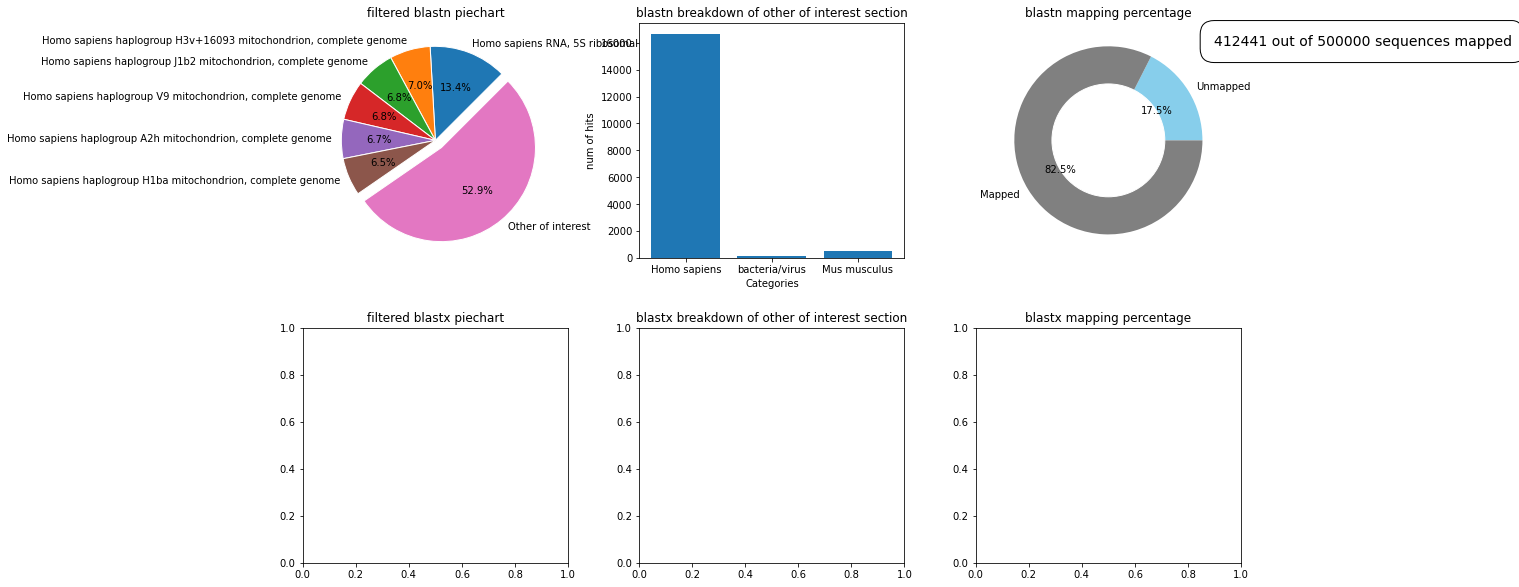

In [24]:
#select intepreter and change environment to anaconda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import xmltodict
from xml.dom import minidom
import time
import yaml


#handles command line input parameter
import sys
import os

with open("/home/s5xu/projects/eclip-qc/config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)


# testing file is from 10,000 reads, so mapping percentage is expected to be out of 10,000
blastn_file = 'LARP6.TGFb_IN1.umi.r1.fq_unmappedblast_downsampled_blastn.tsv'
blastx_file = 'LARP6.TGFb_IN1.umi.r1.fq_unmappedblast_downsampled_blastx.tsv'
# piePath = sys.argv[3]
# piePathSample = os.path.splitext(piePath)[0]
# piePathSample2 = os.path.split(piePathSample)
# pieName = piePathSample2[1]


filterlist = ['bacter', 'bacterium', 'strain', 'Homo sapiens', 'Mus musculus', 'virus']

def esearch(term, db='gds', api_key='9e09d5d38c680a8358426f7fac6d154b4f08'):
    """
    Queries NCBI using the esearch utility. GEO ('gds') database is used as default for search term.
    """
    url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db={db}&term={term}&retmax=5000&usehistory=y&api_key={api_key}'
    try:
        response = urllib.request.urlopen(url)
    except urllib.error.HTTPError:
        return 'No_Species'        
    return response.read()


def get_esummary(esearch_string, db='gds', api_key='9e09d5d38c680a8358426f7fac6d154b4f08'):
    """
    Parses a http response in XML format to obtain the webenv and querykey tokens.
    Uses NCBI eutils to transform these tokens into web summaries of GEO (db='gds') datasets.
    """
    xmldoc = minidom.parseString(esearch_string)
    try:
        webenv = xmldoc.getElementsByTagName('WebEnv')[0].firstChild.data
        querykey = xmldoc.getElementsByTagName('QueryKey')[0].firstChild.data
        host = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi'
        params = f'?db={db}&version=2.0&query_key={querykey}&WebEnv={webenv}&api_key={api_key}'
        url = host + params
        try:
            response = urllib.request.urlopen(url)
        except urllib.error.HTTPError as e:
            print("http error")
            return ""
        return response.read()
    except IndexError as e:
        print(f"Unparsable publication string ({e}, search={esearch_string}")
        return ""



def ncbi_parse(result):
    try:
        return result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
    except TypeError:
        return 'No_Species'
    except KeyError:
        return 'No_Species'


#matplotlib to build the piechart
fig, ((ax1, ax2, ax5), (ax3, ax4, ax6)) = plt.subplots(2, 3, figsize=(9, 5))
fig.tight_layout(h_pad=2)
plt.subplots_adjust(bottom=0, right=1.5, top=1.5)
ax1.set_title('filtered blastn piechart')
ax2.set_title('blastn breakdown of other of interest section')
ax3.set_title('filtered blastx piechart')
ax4.set_title('blastx breakdown of other of interest section')
ax5.set_title('blastn mapping percentage')
ax6.set_title('blastx mapping percentage')





# Creating plots for blastn

# Read the blast n file
origin_blastn = pd.read_csv(blastn_file, header=None, sep='\t')
origin_blastn.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']

origin_blastn2 = origin_blastn[['qseqid','sseqid','pident']].copy()
original_blastn_numseqs = len(origin_blastn)

# all_blastn_freq_dict = {}
# for eachid,eachp in zip(origin_blastn2['sseqid'], origin_blastn2['pident']):
#     if eachid not in all_blastn_freq_dict:
#         all_blastn_freq_dict[eachid] = [eachp, 1]
#     elif float(eachp) > all_blastn_freq_dict[eachid][0]:
#         all_blastn_freq_dict[eachid] = [float(eachp), 1]
#     elif float(eachp) == all_blastn_freq_dict[eachid][0]:
#         all_blastn_freq_dict[eachid][1] += 1

# all_blastn_freq_dict = sorted(all_blastn_freq_dict.items(), key=lambda x:x[1], reverse=True)

# checkqseqid_n = []
# top_blastn_freq_dict = {}
# for eachqid,eachsid,eachp in zip(origin_blastn2['qseqid'],origin_blastn2['sseqid'],origin_blastn2['pident']):
#     if eachqid not in checkqseqid_n:
#         #first instance of qseqid encountered, add top hit
#         checkqseqid_n.append(eachqid)
#         if eachsid not in top_blastn_freq_dict:
#             top_blastn_freq_dict[eachsid] = 1
#         else:
#             top_blastn_freq_dict[eachsid] += 1
#         continue
#     #not the first hit for the qseqid
#     if eachp == 100:
#         if eachsid not in top_blastn_freq_dict:
#             top_blastn_freq_dict[eachsid] = 1
#         else:
#             top_blastn_freq_dict[eachsid] += 1
#     else:
#         #ignore if the score is less than 100 until next qseqid is reached
#         continue

# top_blastn_freq_table = pd.DataFrame(list(top_blastn_freq_dict.items()), columns=['qseqid','frequency'])

# #filter by frequency if frequency is too small TODO
# try:
#     small_hits_interests_of_blastn = []
#     #filter by keywords!
#     for index,row in top_blastn_freq_table.iterrows():
#         term = str(row['qseqid'])
#         #print(term)
#         esearch_string = esearch(term=term, db='nucleotide')
#         if (esearch_string == 'No_Species'):
#             continue
#         time.sleep(0.5)
#         result = get_esummary(esearch_string=esearch_string, db='nucleotide')
#         if result == "":
#             continue
#         result = xmltodict.parse(result)
#         #print(result)
#         sseq_name = ncbi_parse(result)
#         #print(sseq_name)
#         found = False
#         for i in range(len(filterlist)):
#             if filterlist[i] in sseq_name:
#                 top_blastn_freq_table.loc[index, 'qseqid'] = sseq_name
#                 found = True
#         if found == False:
#             small_hits_interests_of_blastn.append(index)
# except Exception as e:
#     error_message = traceback.format_exc()  # Get the error message as a string
#     with open('error_log.txt', 'w') as f:
#         f.write(error_message)
        
# # for i in range(len(small_hits_interests_of_blastn)):
# #     top_blastn_freq_table = top_blastn_freq_table.drop(small_hits_interests_of_blastn[i])
# #top_blastn_freq_table

# top_blastn_freq_table.to_csv('qseqidDf_n.csv')
top_blastn_freq_table = pd.read_csv('qseqidDf_n.csv')

num_seqs_of_interests_blastn = 0 
for index,row in top_blastn_freq_table.iterrows():
    num_seqs_of_interests_blastn += int(row['frequency'])

to_remove_small_hits_blastn = []
other_count_interest_blastn = 0
for index,row in top_blastn_freq_table.iterrows():
    if(row['frequency'] < (0.01)*(original_blastn_numseqs)):
        to_remove_small_hits_blastn.append(index)
        other_count_interest_blastn += int(row['frequency'])

filtered_top_blastn_of_interest = top_blastn_freq_table.drop(index=to_remove_small_hits_blastn)
filtered_top_blastn_of_interest.rename(columns = {'qseqid':'name'}, inplace = True)
filtered_top_blastn_of_interest = filtered_top_blastn_of_interest.reset_index()
filtered_top_blastn_of_interest = filtered_top_blastn_of_interest.drop(filtered_top_blastn_of_interest.columns[1], axis=1)
filtered_top_blastn_of_interest = filtered_top_blastn_of_interest.drop(columns = ('index'))
filtered_top_blastn_of_interest.loc[len(filtered_top_blastn_of_interest)] = ['Other of interest', other_count_interest_blastn]
# filtered_top_blastn_of_interest.loc[len(filtered_top_blastn_of_interest)] = ['Nonrelevant species', original_blastn_numseqs - num_seqs_of_interests_blastn]

filtered_top_blastn_of_interest.to_csv('qseqidDf_n_interest.csv')

blastn_pie1 = filtered_top_blastn_of_interest['frequency']
blastn_pie1_label = filtered_top_blastn_of_interest['name']
blastn_pie_explode = [0 for i in range(len(blastn_pie1)-1)]
blastn_pie_explode.append(0.1)
wedges_blastn, *_ = ax1.pie(blastn_pie1, labels = blastn_pie1_label,explode=blastn_pie_explode,colors=None,autopct='%1.1f%%',startangle=45,
        wedgeprops={"linewidth": 1, "edgecolor": "white"})

filtered_other_blastn_of_interest= top_blastn_freq_table.filter(items = to_remove_small_hits_blastn, axis=0)
blastn_bar_category = ['Homo sapiens','bacteria/virus', 'Mus musculus']
blastn_bar_sum = [0,0,0]
for index,row in filtered_other_blastn_of_interest.iterrows():
    if ('bacteria' or 'bacterium' or 'strain' or 'virus') in row['qseqid']:
        blastn_bar_sum[1] += row['frequency']
    if ('Homo sapiens') in row['qseqid']:
        blastn_bar_sum[0] += row['frequency']
    if ('Mus musculus') in row['qseqid']:
        blastn_bar_sum[2] += row['frequency']
        
ax2.bar(blastn_bar_category,blastn_bar_sum)
ax2.set_ylabel('num of hits')
ax2.set_xlabel('Categories')

### Get the percentage of the the blast n/x mapped results
# for ax5
ax5_percentages = [config['N_downsample_reads']*5 - original_blastn_numseqs, original_blastn_numseqs]
ax5_labels = ['Unmapped', 'Mapped']
ax5.pie(ax5_percentages, labels=ax5_labels, autopct='%1.1f%%',
       colors=['skyblue', 'gray'], labeldistance=1.1)
# Adding Circle in Pie chart
circle1 = plt.Circle((0, 0), radius=0.6, color='white')
ax5.add_patch(circle1)
text1 = str(original_blastn_numseqs) + " out of " + str(config['N_downsample_reads']*5) + " sequences mapped"
ax5.text(0.95, 0.95, text1, transform=ax5.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

print('finish blastn')

fig.tight_layout(pad=5.0)
plt.show(block=True)
# plt.savefig(piePath,format='png',bbox_inches='tight')

In [25]:
#select intepreter and change environment to anaconda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import xmltodict
from xml.dom import minidom
import time
import yaml
import traceback
import urllib.error

#handles command line input parameter
import sys
import os

with open("/home/s5xu/projects/eclip-qc/config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)


# testing file is from 10,000 reads, so mapping percentage is expected to be out of 10,000
blastn_file = 'LARP6.TGFb_IN1.umi.r1.fq_unmappedblast_downsampled_blastn.tsv'
blastx_file = 'LARP6.TGFb_IN1.umi.r1.fq_unmappedblast_downsampled_blastx.tsv'
piePath = 'testing_figure'
# piePathSample = os.path.splitext(piePath)[0]
# piePathSample2 = os.path.split(piePathSample)
# pieName = piePathSample2[1]


filterlist = ['bacter', 'bacterium', 'strain', 'Homo sapiens', 'Mus musculus', 'virus']

def esearch(term, db='gds', api_key='9e09d5d38c680a8358426f7fac6d154b4f08'):
    """
    Queries NCBI using the esearch utility. GEO ('gds') database is used as default for search term.
    """
    url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db={db}&term={term}&retmax=5000&usehistory=y&api_key={api_key}'
    try:
        response = urllib.request.urlopen(url)
    except urllib.error.HTTPError:
        return 'No_Species'        
    return response.read()


def get_esummary(esearch_string, db='gds', api_key='9e09d5d38c680a8358426f7fac6d154b4f08'):
    """
    Parses a http response in XML format to obtain the webenv and querykey tokens.
    Uses NCBI eutils to transform these tokens into web summaries of GEO (db='gds') datasets.
    """
    xmldoc = minidom.parseString(esearch_string)
    try:
        webenv = xmldoc.getElementsByTagName('WebEnv')[0].firstChild.data
        querykey = xmldoc.getElementsByTagName('QueryKey')[0].firstChild.data
        host = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi'
        params = f'?db={db}&version=2.0&query_key={querykey}&WebEnv={webenv}&api_key={api_key}'
        url = host + params
        try:
            response = urllib.request.urlopen(url)
        except urllib.error.HTTPError as e:
            print("http error")
            return ""
        return response.read()
    except IndexError as e:
        print(f"Unparsable publication string ({e}, search={esearch_string}")
        return ""



def ncbi_parse(result):
    try:
        return result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
    except TypeError:
        return 'No_Species'
    except KeyError:
        return 'No_Species'


#matplotlib to build the piechart
fig, ((ax1, ax2, ax5), (ax3, ax4, ax6)) = plt.subplots(2, 3, figsize=(9, 5))
fig.tight_layout(h_pad=2)
plt.subplots_adjust(bottom=0, right=1.5, top=1.5)
ax1.set_title('filtered blastn piechart')
ax2.set_title('blastn breakdown of other of interest section')
ax3.set_title('filtered blastx piechart')
ax4.set_title('blastx breakdown of other of interest section')
ax5.set_title('blastn mapping percentage')
ax6.set_title('blastx mapping percentage')





# Creating plots for blastn

# Read the blast n file
origin_blastn = pd.read_csv(blastn_file, header=None, sep='\t')
origin_blastn.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']

origin_blastn2 = origin_blastn[['qseqid','sseqid','pident']].copy()
original_blastn_numseqs = len(origin_blastn)

all_blastn_freq_dict = {}
for eachid,eachp in zip(origin_blastn2['sseqid'], origin_blastn2['pident']):
    if eachid not in all_blastn_freq_dict:
        all_blastn_freq_dict[eachid] = [eachp, 1]
    elif float(eachp) > all_blastn_freq_dict[eachid][0]:
        all_blastn_freq_dict[eachid] = [float(eachp), 1]
    elif float(eachp) == all_blastn_freq_dict[eachid][0]:
        all_blastn_freq_dict[eachid][1] += 1

all_blastn_freq_dict = sorted(all_blastn_freq_dict.items(), key=lambda x:x[1], reverse=True)

checkqseqid_n = []
top_blastn_freq_dict = {}
for eachqid,eachsid,eachp in zip(origin_blastn2['qseqid'],origin_blastn2['sseqid'],origin_blastn2['pident']):
    if eachqid not in checkqseqid_n:
        #first instance of qseqid encountered, add top hit
        checkqseqid_n.append(eachqid)
        if eachsid not in top_blastn_freq_dict:
            top_blastn_freq_dict[eachsid] = 1
        else:
            top_blastn_freq_dict[eachsid] += 1
        continue
    #not the first hit for the qseqid
    if eachp == 100:
        if eachsid not in top_blastn_freq_dict:
            top_blastn_freq_dict[eachsid] = 1
        else:
            top_blastn_freq_dict[eachsid] += 1
    else:
        #ignore if the score is less than 100 until next qseqid is reached
        continue

top_blastn_freq_table = pd.DataFrame(list(top_blastn_freq_dict.items()), columns=['qseqid','frequency'])

#filter by frequency if frequency is too small TODO
unrelated_hits_of_blastn = []
rerun_list_blastn = []

#filter by keywords!
for index,row in top_blastn_freq_table.iterrows():
    term = str(row['qseqid'])
    print(str(index))
    esearch_string = esearch(term=term, db='nucleotide')
    if (esearch_string == 'No_Species'):
        rerun_list_blastn.append((index,term))
        continue
    time.sleep(0.5)
    result = get_esummary(esearch_string=esearch_string, db='nucleotide')
    if result == "":
        rerun_list_blastn.append((index,term))
        continue
    result = xmltodict.parse(result)
    sseq_name = ncbi_parse(result)
    found = False
    for i in range(len(filterlist)):
        if filterlist[i] in sseq_name:
            top_blastn_freq_table.loc[index, 'qseqid'] = sseq_name
            found = True
    if found == False:
        unrelated_hits_of_blastn.append(index)

#refilter the rerun list that encountered errors before!
for index,term in rerun_list_blastn:
    print(str(index))
    esearch_string = esearch(term=term, db='nucleotide')
    if (esearch_string == 'No_Species'):
        continue
    time.sleep(0.5)
    result = get_esummary(esearch_string=esearch_string, db='nucleotide')
    if result == "":
        continue
    result = xmltodict.parse(result)
    sseq_name = ncbi_parse(result)
    found = False
    for i in range(len(filterlist)):
        if filterlist[i] in sseq_name:
            top_blastn_freq_table.loc[index, 'qseqid'] = sseq_name
            found = True
    if found == False:
        unrelated_hits_of_blastn.append(index)
        
for i in range(len(unrelated_hits_of_blastn)):
    top_blastn_freq_table = top_blastn_freq_table.drop(unrelated_hits_of_blastn[i])
#top_blastn_freq_table

top_blastn_freq_table.to_csv('qseqidDf_n.csv')
# top_blastn_freq_table = pd.read_csv('qseqidDf_n.csv')

num_seqs_of_interests_blastn = 0 
for index,row in top_blastn_freq_table.iterrows():
    num_seqs_of_interests_blastn += int(row['frequency'])

to_remove_small_hits_blastn = []
other_count_interest_blastn = 0
for index,row in top_blastn_freq_table.iterrows():
    if(row['frequency'] < (0.01)*(original_blastn_numseqs)):
        to_remove_small_hits_blastn.append(index)
        other_count_interest_blastn += int(row['frequency'])

filtered_top_blastn_of_interest = top_blastn_freq_table.drop(index=to_remove_small_hits_blastn)
filtered_top_blastn_of_interest.rename(columns = {'qseqid':'name'}, inplace = True)
filtered_top_blastn_of_interest = filtered_top_blastn_of_interest.reset_index()
filtered_top_blastn_of_interest = filtered_top_blastn_of_interest.drop(columns = ('index'))
filtered_top_blastn_of_interest.loc[len(filtered_top_blastn_of_interest)] = ['Other of interest', other_count_interest_blastn]
# filtered_top_blastn_of_interest.loc[len(filtered_top_blastn_of_interest)] = ['Nonrelevant species', original_blastn_numseqs - num_seqs_of_interests_blastn]

filtered_top_blastn_of_interest.to_csv('qseqidDf_n_interest.csv')

blastn_pie1 = filtered_top_blastn_of_interest['frequency']
blastn_pie1_label = filtered_top_blastn_of_interest['name']
blastn_pie_explode = [0 for i in range(len(blastn_pie1)-1)]
blastn_pie_explode.append(0.1)
wedges_blastn, *_ = ax1.pie(blastn_pie1, labels = blastn_pie1_label,explode=blastn_pie_explode,colors=None,autopct='%1.1f%%',startangle=45,
        wedgeprops={"linewidth": 1, "edgecolor": "white"})

filtered_other_blastn_of_interest= top_blastn_freq_table.filter(items = to_remove_small_hits_blastn, axis=0)
blastn_bar_category = ['Homo sapiens','bacteria/virus', 'Mus musculus']
blastn_bar_sum = [0,0,0]
for index,row in filtered_other_blastn_of_interest.iterrows():
    if ('bacteria' or 'bacterium' or 'strain' or 'virus') in row['qseqid']:
        blastn_bar_sum[1] += row['frequency']
    if ('Homo sapiens') in row['qseqid']:
        blastn_bar_sum[0] += row['frequency']
    if ('Mus musculus') in row['qseqid']:
        blastn_bar_sum[2] += row['frequency']
        
ax2.bar(blastn_bar_category,blastn_bar_sum)
ax2.set_ylabel('num of hits')
ax2.set_xlabel('Categories')

### Get the percentage of the the blast n/x mapped results
# for ax5
ax5_percentages = [config['N_downsample_reads']*5 - original_blastn_numseqs, original_blastn_numseqs]
ax5_labels = ['Unmapped', 'Mapped']
ax5.pie(ax5_percentages, labels=ax5_labels, autopct='%1.1f%%',
       colors=['skyblue', 'gray'], labeldistance=1.1)
# Adding Circle in Pie chart
circle1 = plt.Circle((0, 0), radius=0.6, color='white')
ax5.add_patch(circle1)
text1 = str(original_blastn_numseqs) + " out of " + str(config['N_downsample_reads']*5) + " sequences mapped"
ax5.text(0.95, 0.95, text1, transform=ax5.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

print('finish blastn')











# Creating plots for blastx

# Read the blast x file
origin_blastx = pd.read_csv(blastx_file, header=None, sep='\t')
origin_blastx.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']

origin_blastx2 = origin_blastx[['qseqid','sseqid','pident']].copy()
original_blastx_numseqs = len(origin_blastx)

all_blastx_freq_dict = {}
for eachid,eachp in zip(origin_blastx2['sseqid'], origin_blastx2['pident']):
    if eachid not in all_blastx_freq_dict:
        all_blastx_freq_dict[eachid] = [eachp, 1]
    elif float(eachp) > all_blastx_freq_dict[eachid][0]:
        all_blastx_freq_dict[eachid] = [float(eachp), 1]
    elif float(eachp) == all_blastx_freq_dict[eachid][0]:
        all_blastx_freq_dict[eachid][1] += 1

all_blastx_freq_dict = sorted(all_blastx_freq_dict.items(), key=lambda x:x[1], reverse=True)

checkqseqid_x = []
top_blastx_freq_dict = {}
for eachqid,eachsid,eachp in zip(origin_blastx2['qseqid'],origin_blastx2['sseqid'],origin_blastx2['pident']):
    if eachqid not in checkqseqid_x:
        #first instance of qseqid encountered, add top hit
        checkqseqid_x.append(eachqid)
        if eachsid not in top_blastx_freq_dict:
            top_blastx_freq_dict[eachsid] = 1
        else:
            top_blastx_freq_dict[eachsid] += 1
        continue
    #not the first hit for the qseqid
    if eachp == 100:
        if eachsid not in top_blastx_freq_dict:
            top_blastx_freq_dict[eachsid] = 1
        else:
            top_blastx_freq_dict[eachsid] += 1
    else:
        #ignore if the score is less than 100 until next qseqid is reached
        continue

top_blastx_freq_table = pd.DataFrame(list(top_blastx_freq_dict.items()), columns=['qseqid','frequency'])

# filter by frequency if frequency is too small TODO
unrelated_hits_of_blastx = []
rerun_list_blastx = []

#filter by keywords!
for index,row in top_blastx_freq_table.iterrows():
    term = str(row['qseqid'])
    print(str(index))
    esearch_string = esearch(term=term, db='protein')
    if (esearch_string == 'No_Species'):
        rerun_list_blastx.append((index,term))
        continue
    time.sleep(0.5)
    result = get_esummary(esearch_string=esearch_string, db='protein')
    if result == "":
        rerun_list_blastx.append((index,term))
        continue
    result = xmltodict.parse(result)
    sseq_name = ncbi_parse(result)
    found = False
    for i in range(len(filterlist)):
        if filterlist[i] in sseq_name:
            top_blastx_freq_table.loc[index, 'qseqid'] = sseq_name
            found = True
    if found == False:
        unrelated_hits_of_blastx.append(index)

#refilter the rerun list that encountered errors before!
for index,term in rerun_list_blastx:
    print(str(index))
    esearch_string = esearch(term=term, db='protein')
    if (esearch_string == 'No_Species'):
        continue
    time.sleep(0.5)
    result = get_esummary(esearch_string=esearch_string, db='protein')
    if result == "":
        continue
    result = xmltodict.parse(result)
    sseq_name = ncbi_parse(result)
    found = False
    for i in range(len(filterlist)):
        if filterlist[i] in sseq_name:
            top_blastn_freq_table.loc[index, 'qseqid'] = sseq_name
            found = True
    if found == False:
        unrelated_hits_of_blastx.append(index)

for i in range(len(unrelated_hits_of_blastx)):
    top_blastx_freq_table = top_blastx_freq_table.drop(unrelated_hits_of_blastx[i])
#top_blastx_freq_table

top_blastx_freq_table.to_csv('qseqidDf_x.csv')
# # top_blastx_freq_table = pd.read_csv('qseqidDf_x.csv')

num_seqs_of_interests_blastx = 0 
for index,row in top_blastx_freq_table.iterrows():
    num_seqs_of_interests_blastx += int(row['frequency'])

to_remove_small_hits_blastx = []
other_count_interest_blastx = 0
for index,row in top_blastx_freq_table.iterrows():
    if(row['frequency'] < (0.01)*(original_blastx_numseqs)):
        to_remove_small_hits_blastx.append(index)
        other_count_interest_blastx += int(row['frequency'])

filtered_top_blastx_of_interest = top_blastx_freq_table.drop(index=to_remove_small_hits_blastx)
filtered_top_blastx_of_interest.rename(columns = {'qseqid':'name'}, inplace = True)
filtered_top_blastx_of_interest = filtered_top_blastx_of_interest.reset_index()
filtered_top_blastx_of_interest = filtered_top_blastx_of_interest.drop(columns = ('index'))
filtered_top_blastx_of_interest.loc[len(filtered_top_blastx_of_interest)] = ['Other of interest', other_count_interest_blastx]
# filtered_top_blastx_of_interest.loc[len(filtered_top_blastn_of_interest)] = ['Nonrelevant species', original_blastn_numseqs - num_seqs_of_interests_blastn]

filtered_top_blastx_of_interest.to_csv('qseqidDf_x_interest.csv')

blastx_pie1 = filtered_top_blastx_of_interest['frequency']
blastx_pie1_label = filtered_top_blastx_of_interest['name']
blastx_pie_explode = [0 for i in range(len(blastx_pie1)-1)]
blastx_pie_explode.append(0.1)
wedges_blastx, *_ = ax3.pie(blastx_pie1, labels = blastx_pie1_label,explode=blastx_pie_explode,colors=None,autopct='%1.1f%%',startangle=45,
        wedgeprops={"linewidth": 1, "edgecolor": "white"})

filtered_other_blastx_of_interest= top_blastx_freq_table.filter(items = to_remove_small_hits_blastx, axis=0)
blastx_bar_category = ['Homo sapiens','bacteria/virus', 'Mus musculus']
blastx_bar_sum = [0,0,0]
for index,row in filtered_other_blastx_of_interest.iterrows():
    if ('bacteria' or 'bacterium' or 'strain' or 'virus') in row['qseqid']:
        blastx_bar_sum[1] += row['frequency']
    if ('Homo sapiens') in row['qseqid']:
        blastx_bar_sum[0] += row['frequency']
    if ('Mus musculus') in row['qseqid']:
        blastx_bar_sum[2] += row['frequency']
        
ax4.bar(blastx_bar_category,blastx_bar_sum)
ax4.set_ylabel('num of hits')
ax4.set_xlabel('Categories')

### Get the percentage of the the blast n/x mapped results
# for ax5
ax6_percentages = [config['N_downsample_reads']*5 - original_blastx_numseqs, original_blastx_numseqs]
ax6_labels = ['Unmapped', 'Mapped']
ax6.pie(ax6_percentages, labels=ax6_labels, autopct='%1.1f%%',
       colors=['skyblue', 'gray'], labeldistance=1.1)
# Adding Circle in Pie chart
circle2 = plt.Circle((0, 0), radius=0.6, color='white')
ax6.add_patch(circle2)
text2 = str(original_blastx_numseqs) + " out of " + str(config['N_downsample_reads']*5) + " sequences mapped"
ax6.text(0.95, 0.95, text2, transform=ax6.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))


print('finish blastx')


fig.tight_layout(pad=5.0)
plt.show(block=True)
plt.savefig(piePath,format='png',bbox_inches='tight')

finish blastn
finish blastx


/tmp/ipykernel_3895/213215630.py:459: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=5.0)


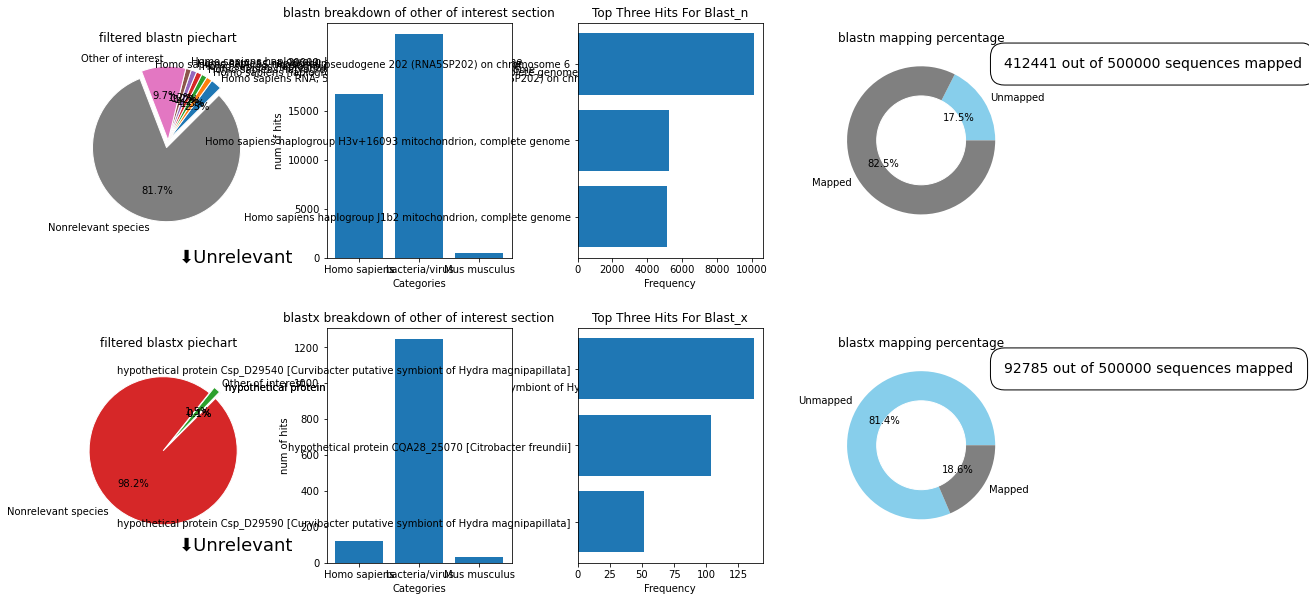

<Figure size 432x288 with 0 Axes>

In [28]:
#select intepreter and change environment to anaconda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import xmltodict
from xml.dom import minidom
import time
import yaml
import traceback
import urllib.error

#handles command line input parameter
import sys
import os

with open("/home/s5xu/projects/eclip-qc/config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)


# testing file is from 10,000 reads, so mapping percentage is expected to be out of 10,000
blastn_file = 'LARP6.TGFb_IN1.umi.r1.fq_unmappedblast_downsampled_blastn.tsv'
blastx_file = 'LARP6.TGFb_IN1.umi.r1.fq_unmappedblast_downsampled_blastx.tsv'
piePath = 'fff'
# piePathSample = os.path.splitext(piePath)[0]
# piePathSample2 = os.path.split(piePathSample)
# pieName = piePathSample2[1]


filterlist = ['bacter', 'bacterium', 'strain', 'Homo sapiens', 'Mus musculus', 'virus']

def esearch(term, db='gds', api_key='9e09d5d38c680a8358426f7fac6d154b4f08'):
    """
    Queries NCBI using the esearch utility. GEO ('gds') database is used as default for search term.
    """
    url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db={db}&term={term}&retmax=5000&usehistory=y&api_key={api_key}'
    try:
        response = urllib.request.urlopen(url)
    except urllib.error.HTTPError:
        return 'No_Species'        
    return response.read()


def get_esummary(esearch_string, db='gds', api_key='9e09d5d38c680a8358426f7fac6d154b4f08'):
    """
    Parses a http response in XML format to obtain the webenv and querykey tokens.
    Uses NCBI eutils to transform these tokens into web summaries of GEO (db='gds') datasets.
    """
    xmldoc = minidom.parseString(esearch_string)
    try:
        webenv = xmldoc.getElementsByTagName('WebEnv')[0].firstChild.data
        querykey = xmldoc.getElementsByTagName('QueryKey')[0].firstChild.data
        host = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi'
        params = f'?db={db}&version=2.0&query_key={querykey}&WebEnv={webenv}&api_key={api_key}'
        url = host + params
        try:
            response = urllib.request.urlopen(url)
        except urllib.error.HTTPError as e:
            print("http error")
            return ""
        return response.read()
    except IndexError as e:
        print(f"Unparsable publication string ({e}, search={esearch_string}")
        return ""



def ncbi_parse(result):
    try:
        return result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
    except TypeError:
        return 'No_Species'
    except KeyError:
        return 'No_Species'


#matplotlib to build the piechart
fig, ((ax1, ax2, ax7, ax5), (ax3, ax4, ax8, ax6)) = plt.subplots(2, 4, figsize=(9, 5))
fig.tight_layout(h_pad=2)
plt.subplots_adjust(bottom=0, right=1.5, top=1.5)
ax1.set_title('filtered blastn piechart')
ax2.set_title('blastn breakdown of other of interest section')
ax3.set_title('filtered blastx piechart')
ax4.set_title('blastx breakdown of other of interest section')
ax5.set_title('blastn mapping percentage')
ax6.set_title('blastx mapping percentage')





# Creating plots for blastn

# Read the blast n file
origin_blastn = pd.read_csv(blastn_file, header=None, sep='\t')
origin_blastn.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']

origin_blastn2 = origin_blastn[['qseqid','sseqid','pident']].copy()
original_blastn_numseqs = len(origin_blastn)

# all_blastn_freq_dict = {}
# for eachid,eachp in zip(origin_blastn2['sseqid'], origin_blastn2['pident']):
#     if eachid not in all_blastn_freq_dict:
#         all_blastn_freq_dict[eachid] = [eachp, 1]
#     elif float(eachp) > all_blastn_freq_dict[eachid][0]:
#         all_blastn_freq_dict[eachid] = [float(eachp), 1]
#     elif float(eachp) == all_blastn_freq_dict[eachid][0]:
#         all_blastn_freq_dict[eachid][1] += 1

# all_blastn_freq_dict = sorted(all_blastn_freq_dict.items(), key=lambda x:x[1], reverse=True)

# checkqseqid_n = []
# top_blastn_freq_dict = {}
# for eachqid,eachsid,eachp in zip(origin_blastn2['qseqid'],origin_blastn2['sseqid'],origin_blastn2['pident']):
#     if eachqid not in checkqseqid_n:
#         #first instance of qseqid encountered, add top hit
#         checkqseqid_n.append(eachqid)
#         if eachsid not in top_blastn_freq_dict:
#             top_blastn_freq_dict[eachsid] = 1
#         else:
#             top_blastn_freq_dict[eachsid] += 1
#         continue
#     #not the first hit for the qseqid
#     if eachp == 100:
#         if eachsid not in top_blastn_freq_dict:
#             top_blastn_freq_dict[eachsid] = 1
#         else:
#             top_blastn_freq_dict[eachsid] += 1
#     else:
#         #ignore if the score is less than 100 until next qseqid is reached
#         continue

# top_blastn_freq_table = pd.DataFrame(list(top_blastn_freq_dict.items()), columns=['qseqid','frequency'])

# #filter by frequency if frequency is too small TODO
# unrelated_hits_of_blastn = []
# rerun_list_blastn = []

# #filter by keywords!
# for index,row in top_blastn_freq_table.iterrows():
#     term = str(row['qseqid'])
#     print(str(index))
#     esearch_string = esearch(term=term, db='nucleotide')
#     if (esearch_string == 'No_Species'):
#         rerun_list_blastn.append((index,term))
#         continue
#     time.sleep(0.5)
#     result = get_esummary(esearch_string=esearch_string, db='nucleotide')
#     if result == "":
#         rerun_list_blastn.append((index,term))
#         continue
#     result = xmltodict.parse(result)
#     sseq_name = ncbi_parse(result)
#     found = False
#     for i in range(len(filterlist)):
#         if filterlist[i] in sseq_name:
#             top_blastn_freq_table.loc[index, 'qseqid'] = sseq_name
#             found = True
#     if found == False:
#         unrelated_hits_of_blastn.append(index)

# #refilter the rerun list that encountered errors before!
# for index,term in rerun_list_blastn:
#     print(str(index))
#     esearch_string = esearch(term=term, db='nucleotide')
#     if (esearch_string == 'No_Species'):
#         continue
#     time.sleep(0.5)
#     result = get_esummary(esearch_string=esearch_string, db='nucleotide')
#     if result == "":
#         continue
#     result = xmltodict.parse(result)
#     sseq_name = ncbi_parse(result)
#     found = False
#     for i in range(len(filterlist)):
#         if filterlist[i] in sseq_name:
#             top_blastn_freq_table.loc[index, 'qseqid'] = sseq_name
#             found = True
#     if found == False:
#         unrelated_hits_of_blastn.append(index)
        
# for i in range(len(unrelated_hits_of_blastn)):
#     top_blastn_freq_table = top_blastn_freq_table.drop(unrelated_hits_of_blastn[i])
# #top_blastn_freq_table

# top_blastn_freq_table.to_csv('qseqidDf_n.csv')
top_blastn_freq_table = pd.read_csv('qseqidDf_n.csv')
top_blastn_freq_table.drop(top_blastn_freq_table.columns[0], axis=1, inplace=True)

num_seqs_of_interests_blastn = 0 
for index,row in top_blastn_freq_table.iterrows():
    num_seqs_of_interests_blastn += int(row['frequency'])

to_remove_small_hits_blastn = []
other_count_interest_blastn = 0
top_three_blastn = []
top_blastn_freq_table = top_blastn_freq_table.sort_values(by="frequency",ascending=False)
for index,row in top_blastn_freq_table.iterrows():
    if len(top_three_blastn) < 3:
        top_three_blastn.append((row['frequency'],row['qseqid']))
    if(row['frequency'] < (0.01)*(original_blastn_numseqs)):
        to_remove_small_hits_blastn.append(index)
        other_count_interest_blastn += int(row['frequency'])

filtered_top_blastn_of_interest = top_blastn_freq_table.drop(index=to_remove_small_hits_blastn)
filtered_top_blastn_of_interest.rename(columns = {'qseqid':'name'}, inplace = True)
filtered_top_blastn_of_interest = filtered_top_blastn_of_interest.reset_index()
filtered_top_blastn_of_interest = filtered_top_blastn_of_interest.drop(columns = ('index'))
filtered_top_blastn_of_interest.loc[len(filtered_top_blastn_of_interest)] = ['Other of interest', other_count_interest_blastn]
filtered_top_blastn_of_interest.loc[len(filtered_top_blastn_of_interest)] = ['Nonrelevant species', original_blastn_numseqs - num_seqs_of_interests_blastn]

# filtered_top_blastn_of_interest.to_csv('qseqidDf_n_interest.csv')
# filtered_top_blastn_of_interest = pd.read_csv('qseqidDf_n_interest.csv')

blastn_pie1 = filtered_top_blastn_of_interest['frequency']
blastn_pie1_label = filtered_top_blastn_of_interest['name']
blastn_pie_explode = [0 for i in range(len(blastn_pie1)-1)]
blastn_pie_explode.append(0.1)
wedges_blastn, *_ = ax1.pie(blastn_pie1, labels = blastn_pie1_label,explode=blastn_pie_explode,colors=None,autopct='%1.1f%%',startangle=45,
        wedgeprops={"linewidth": 1, "edgecolor": "white"})

filtered_other_blastn_of_interest= top_blastn_freq_table.filter(items = to_remove_small_hits_blastn, axis=0)
blastn_bar_category = ['Homo sapiens','bacteria/virus', 'Mus musculus']
blastn_bar_sum = [0,0,0]
for index,row in filtered_other_blastn_of_interest.iterrows():
    if ('Homo sapiens') in row['qseqid']:
        blastn_bar_sum[0] += row['frequency']
    elif ('bacter') in row['qseqid']:
        blastn_bar_sum[1] += row['frequency']
    elif ('bacterium') in row['qseqid']:
        blastn_bar_sum[1] += row['frequency']
    elif ('strain') in row['qseqid']:
        blastn_bar_sum[1] += row['frequency']
    elif ('virus') in row['qseqid']:
        blastn_bar_sum[1] += row['frequency']
    elif ('Mus musculus') in row['qseqid']:
        blastn_bar_sum[2] += row['frequency']
        
ax2.bar(blastn_bar_category,blastn_bar_sum)
ax2.set_ylabel('num of hits')
ax2.set_xlabel('Categories')

### Show the top three hits for blastn by horizontal bar
ax7_three_seqs_freq = [x[0] for x in top_three_blastn]
ax7_three_seqs_freq.reverse()
ax7_three_seqs_label = [x[1] for x in top_three_blastn]
ax7_three_seqs_label.reverse()
ax7.barh(ax7_three_seqs_label,ax7_three_seqs_freq, align='center')
ax7.set_xlabel('Frequency')
ax7.set_title('Top Three Hits For Blast_n')

### Get the percentage of the the blast n/x mapped results
# for ax5
ax5_percentages = [config['N_downsample_reads']*5 - original_blastn_numseqs, original_blastn_numseqs]
ax5_labels = ['Unmapped', 'Mapped']
ax5.pie(ax5_percentages, labels=ax5_labels, autopct='%1.1f%%',
       colors=['skyblue', 'gray'], labeldistance=1.1)
# Adding Circle in Pie chart
circle1 = plt.Circle((0, 0), radius=0.6, color='white')
ax5.add_patch(circle1)
text1 = str(original_blastn_numseqs) + " out of " + str(config['N_downsample_reads']*5) + " sequences mapped"
ax5.text(0.95, 0.95, text1, transform=ax5.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

print('finish blastn')











# Creating plots for blastx

# Read the blast x file
origin_blastx = pd.read_csv(blastx_file, header=None, sep='\t')
origin_blastx.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']

origin_blastx2 = origin_blastx[['qseqid','sseqid','pident']].copy()
original_blastx_numseqs = len(origin_blastx)

# # all_blastx_freq_dict = {}
# # for eachid,eachp in zip(origin_blastx2['sseqid'], origin_blastx2['pident']):
# #     if eachid not in all_blastx_freq_dict:
# #         all_blastx_freq_dict[eachid] = [eachp, 1]
# #     elif float(eachp) > all_blastx_freq_dict[eachid][0]:
# #         all_blastx_freq_dict[eachid] = [float(eachp), 1]
# #     elif float(eachp) == all_blastx_freq_dict[eachid][0]:
# #         all_blastx_freq_dict[eachid][1] += 1

# # all_blastx_freq_dict = sorted(all_blastx_freq_dict.items(), key=lambda x:x[1], reverse=True)

# # checkqseqid_x = []
# # top_blastx_freq_dict = {}
# # for eachqid,eachsid,eachp in zip(origin_blastx2['qseqid'],origin_blastx2['sseqid'],origin_blastx2['pident']):
# #     if eachqid not in checkqseqid_x:
# #         #first instance of qseqid encountered, add top hit
# #         checkqseqid_x.append(eachqid)
# #         if eachsid not in top_blastx_freq_dict:
# #             top_blastx_freq_dict[eachsid] = 1
# #         else:
# #             top_blastx_freq_dict[eachsid] += 1
# #         continue
# #     #not the first hit for the qseqid
# #     if eachp == 100:
# #         if eachsid not in top_blastx_freq_dict:
# #             top_blastx_freq_dict[eachsid] = 1
# #         else:
# #             top_blastx_freq_dict[eachsid] += 1
# #     else:
# #         #ignore if the score is less than 100 until next qseqid is reached
# #         continue

# # top_blastx_freq_table = pd.DataFrame(list(top_blastx_freq_dict.items()), columns=['qseqid','frequency'])

# # # filter by frequency if frequency is too small TODO
# # unrelated_hits_of_blastx = []
# # rerun_list_blastx = []

# # #filter by keywords!
# # for index,row in top_blastx_freq_table.iterrows():
# #     term = str(row['qseqid'])
# #     print(str(index))
# #     esearch_string = esearch(term=term, db='protein')
# #     if (esearch_string == 'No_Species'):
# #         rerun_list_blastx.append((index,term))
# #         continue
# #     time.sleep(0.5)
# #     result = get_esummary(esearch_string=esearch_string, db='protein')
# #     if result == "":
# #         rerun_list_blastx.append((index,term))
# #         continue
# #     result = xmltodict.parse(result)
# #     sseq_name = ncbi_parse(result)
# #     found = False
# #     for i in range(len(filterlist)):
# #         if filterlist[i] in sseq_name:
# #             top_blastx_freq_table.loc[index, 'qseqid'] = sseq_name
# #             found = True
# #     if found == False:
# #         unrelated_hits_of_blastx.append(index)

# # #refilter the rerun list that encountered errors before!
# # for index,term in rerun_list_blastx:
# #     print(str(index))
# #     esearch_string = esearch(term=term, db='protein')
# #     if (esearch_string == 'No_Species'):
# #         continue
# #     time.sleep(0.5)
# #     result = get_esummary(esearch_string=esearch_string, db='protein')
# #     if result == "":
# #         continue
# #     result = xmltodict.parse(result)
# #     sseq_name = ncbi_parse(result)
# #     found = False
# #     for i in range(len(filterlist)):
# #         if filterlist[i] in sseq_name:
# #             top_blastn_freq_table.loc[index, 'qseqid'] = sseq_name
# #             found = True
# #     if found == False:
# #         unrelated_hits_of_blastx.append(index)

# # for i in range(len(unrelated_hits_of_blastx)):
# #     top_blastx_freq_table = top_blastx_freq_table.drop(unrelated_hits_of_blastx[i])
# # #top_blastx_freq_table

# # top_blastx_freq_table.to_csv('qseqidDf_x.csv')
top_blastx_freq_table = pd.read_csv('qseqidDf_x.csv')
top_blastx_freq_table.drop(top_blastx_freq_table.columns[0], axis=1, inplace=True)
num_seqs_of_interests_blastx = 0 
for index,row in top_blastx_freq_table.iterrows():
    num_seqs_of_interests_blastx += int(row['frequency'])

to_remove_small_hits_blastx = []
other_count_interest_blastx = 0
top_three_blastx = []
top_blastx_freq_table = top_blastx_freq_table.sort_values(by="frequency",ascending=False)
for index,row in top_blastx_freq_table.iterrows():
    if len(top_three_blastx) < 3:
        top_three_blastx.append((row['frequency'],row['qseqid']))
    if(row['frequency'] < (0.001)*(original_blastx_numseqs)):
        to_remove_small_hits_blastx.append(index)
        other_count_interest_blastx += int(row['frequency'])

filtered_top_blastx_of_interest = top_blastx_freq_table.drop(index=to_remove_small_hits_blastx)
filtered_top_blastx_of_interest.rename(columns = {'qseqid':'name'}, inplace = True)
filtered_top_blastx_of_interest = filtered_top_blastx_of_interest.reset_index()
filtered_top_blastx_of_interest = filtered_top_blastx_of_interest.drop(columns = ('index'))
filtered_top_blastx_of_interest.loc[len(filtered_top_blastx_of_interest)] = ['Other of interest', other_count_interest_blastx]
filtered_top_blastx_of_interest.loc[len(filtered_top_blastx_of_interest)] = ['Nonrelevant species', original_blastx_numseqs - num_seqs_of_interests_blastx]

# filtered_top_blastx_of_interest.to_csv('qseqidDf_x_interest.csv')
# filtered_top_blastx_of_interest = pd.read_csv('qseqidDf_x_interest.csv')

blastx_pie1 = filtered_top_blastx_of_interest['frequency']
blastx_pie1_label = filtered_top_blastx_of_interest['name']
blastx_pie_explode = [0 for i in range(len(blastx_pie1)-1)]
blastx_pie_explode.append(0.1)
wedges_blastx, *_ = ax3.pie(blastx_pie1, labels = blastx_pie1_label,explode=blastx_pie_explode,colors=None,autopct='%1.1f%%',startangle=45,
        wedgeprops={"linewidth": 1, "edgecolor": "white"})

filtered_other_blastx_of_interest= top_blastx_freq_table.filter(items = to_remove_small_hits_blastx, axis=0)
blastx_bar_category = ['Homo sapiens','bacteria/virus', 'Mus musculus']
blastx_bar_sum = [0,0,0]
for index,row in filtered_other_blastx_of_interest.iterrows():
    if ('Homo sapiens') in row['qseqid']:
        blastx_bar_sum[0] += row['frequency']
    elif ('bacter') in row['qseqid']:
        blastx_bar_sum[1] += row['frequency']
    elif ('bacterium') in row['qseqid']:
        blastx_bar_sum[1] += row['frequency']
    elif ('strain') in row['qseqid']:
        blastx_bar_sum[1] += row['frequency']
    elif ('virus') in row['qseqid']:
        blastx_bar_sum[1] += row['frequency']
    elif ('Mus musculus') in row['qseqid']:
        blastx_bar_sum[2] += row['frequency']
        
ax4.bar(blastx_bar_category,blastx_bar_sum)
ax4.set_ylabel('num of hits')
ax4.set_xlabel('Categories')

### Show the top three hits for blastx by horizontal bar
ax8_three_seqs_freq = [x[0] for x in top_three_blastx]
ax8_three_seqs_freq.reverse()
ax8_three_seqs_label = [x[1] for x in top_three_blastx]
ax8_three_seqs_label.reverse()
ax8.barh(ax8_three_seqs_label,ax8_three_seqs_freq, align='center')
ax8.set_xlabel('Frequency')
ax8.set_title('Top Three Hits For Blast_x')

### Get the percentage of the the blast n/x mapped results
# for ax5
ax6_percentages = [config['N_downsample_reads']*5 - original_blastx_numseqs, original_blastx_numseqs]
ax6_labels = ['Unmapped', 'Mapped']
ax6.pie(ax6_percentages, labels=ax6_labels, autopct='%1.1f%%',
       colors=['skyblue', 'gray'], labeldistance=1.1)
# Adding Circle in Pie chart
circle2 = plt.Circle((0, 0), radius=0.6, color='white')
ax6.add_patch(circle2)
text2 = str(original_blastx_numseqs) + " out of " + str(config['N_downsample_reads']*5) + " sequences mapped"
ax6.text(0.95, 0.95, text2, transform=ax6.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))


print('finish blastx')


# plt.subplots_adjust(hspace=0.4, wspace=0.9)
fig.text(0.3, 0.85, '⬇Unrelevant', ha='center', va='center', fontsize=18)
fig.text(0.3, 0.05, '⬇Unrelevant', ha='center', va='center', fontsize=18)



fig.tight_layout(pad=5.0)
plt.show(block=True)
# plt.savefig(piePath,format='png',bbox_inches='tight')

In [1]:
import sys
import os
piePath = 'pieChart/sample.png'
piePathSample = os.path.splitext(piePath)[0]
piePathSample2 = os.path.split(piePathSample)
pieName = piePathSample2[1]

In [2]:
pieName

'sample'

In [5]:
piePathSample

'pieChart/sample'

In [1]:
#select intepreter and change environment to anaconda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import xmltodict
from xml.dom import minidom
import time
import yaml
import traceback
import urllib.error

#handles command line input parameter
import sys
import os

with open("/home/s5xu/projects/eclip-qc/config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-77s_o11p because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
look = pd.read_csv('IP_n_interest.csv')

In [5]:
look

,Unnamed: 0,name,frequency
0,0,Burkholderia ambifaria strain B21-004 chromoso...,3583
1,1,Burkholderia ambifaria strain B21-004 chromoso...,3033
2,2,Burkholderia ambifaria strain B21-004 chromoso...,2444
3,3,"Phyllobacterium sp. T1293 plasmid pT1293c, com...",1963
4,4,"Phyllobacterium sp. T1293 chromosome, complete...",1930
5,5,Other of interest,99602
6,6,Nonrelevant species,70617
